Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [51]:
install.packages(c("tidymodels", "readr", "moderndive"))

library('tidymodels')
library('readr')
library('moderndive')


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [52]:
hate_crimes <- read_csv("http://bit.ly/2ItxYg3")

Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): state, median_house_inc, trump_support, unemployment, urbanization
dbl (4): share_pop_metro, hs, hate_crimes, income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

Warning message:
“`geom_parallel_slopes()` doesn't need a `method` argument ("lm" is used).”
Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_parallel_slopes()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


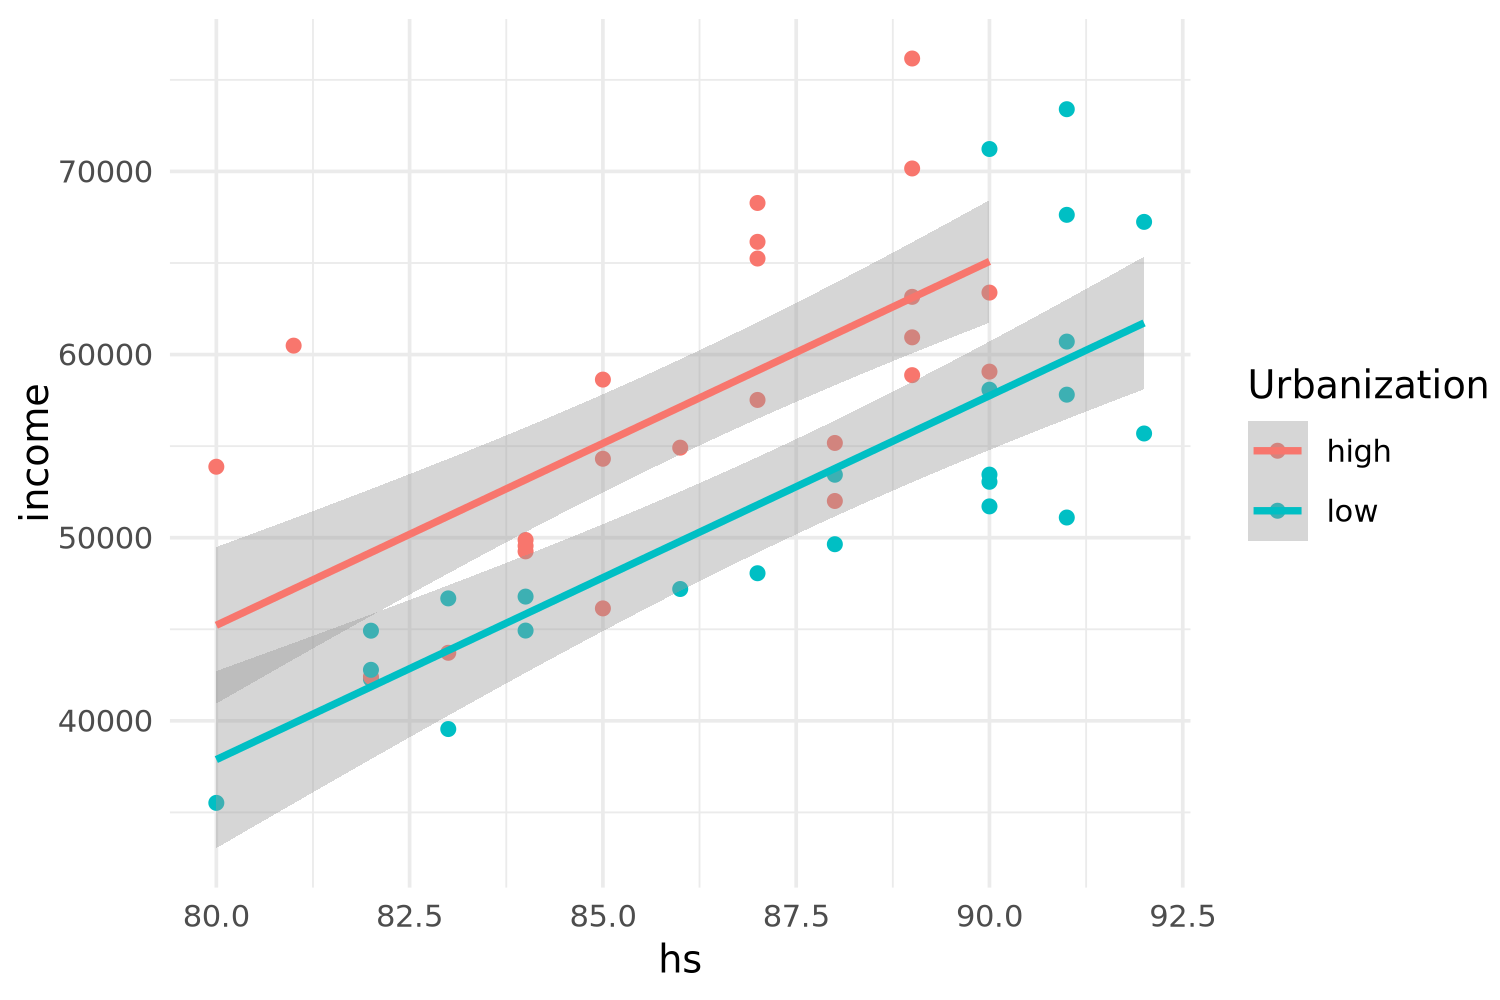

In [53]:
options(repr.plot.height = 4, repr.plot.width = 6)

ggplot(hate_crimes) +
    geom_point(aes(x = hs, y = income, color = factor(urbanization))) +
    labs(color = 'Urbanization') +
    geom_parallel_slopes(aes(x = hs, y = income, color = factor(urbanization)), method = "lm") +
    theme_minimal()

❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**


The line where Urbanization is the highest has the largest intercept, since the lines run parallel to each other and the read line is higher. This means that no matter what, the red line would always cross at a higher intercept. 


Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


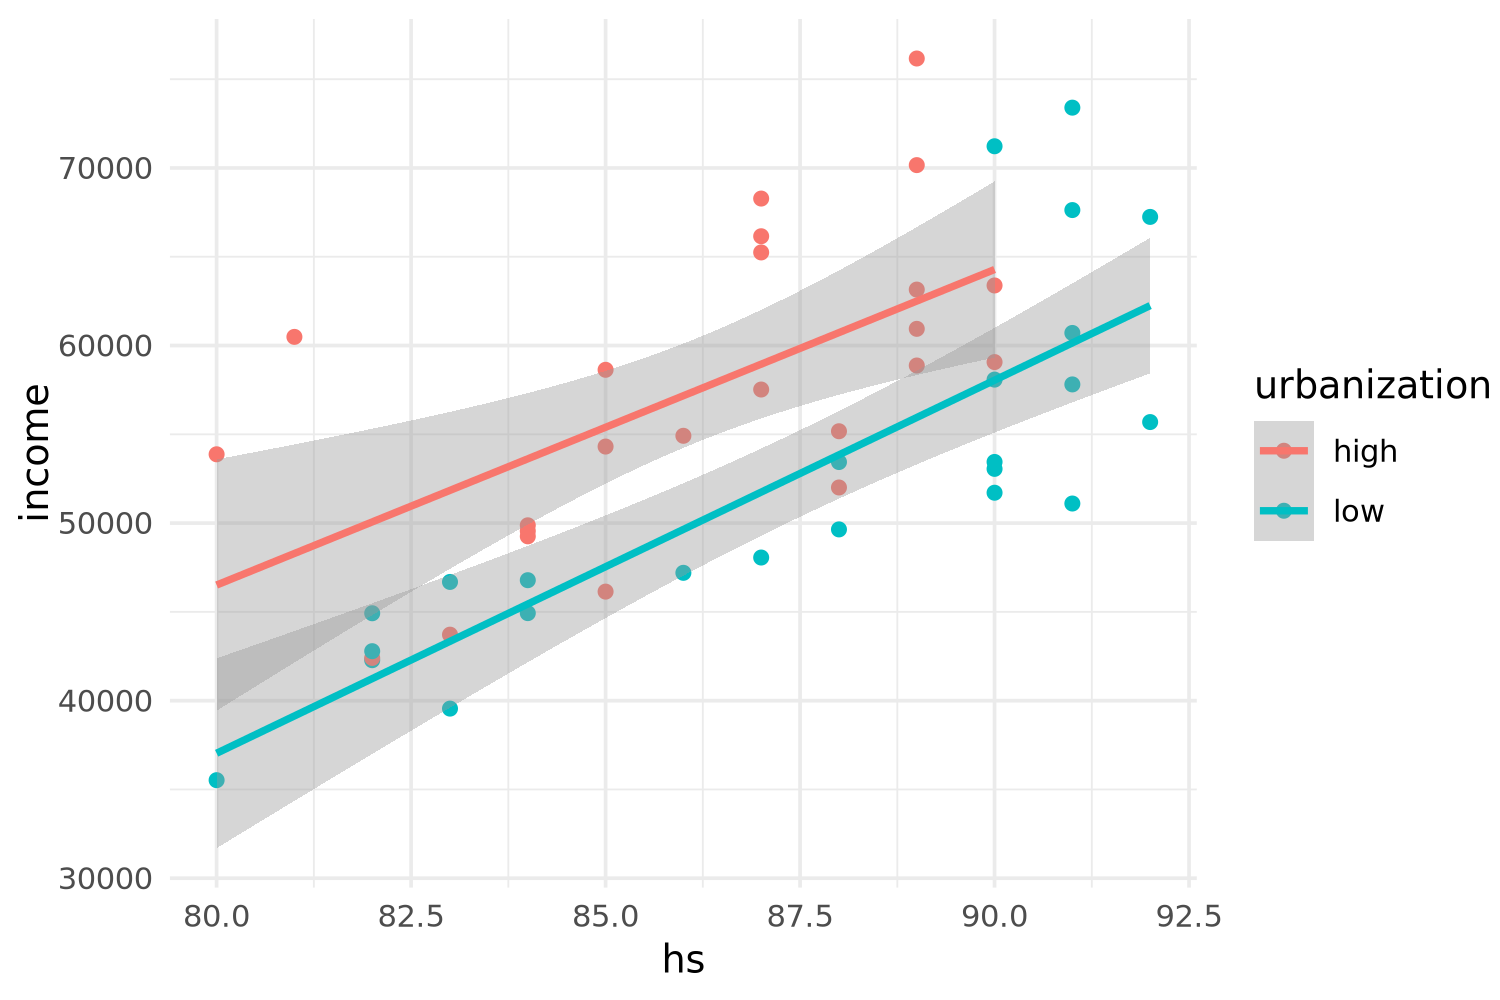

In [66]:
options(repr.plot.height = 4, repr.plot.width = 6)

ggplot(hate_crimes) +
    geom_point(aes(x = hs, y = income, color = factor(urbanization))) +
    labs(color = 'urbanization') +
    geom_smooth(aes(x = hs, y = income, color = factor(urbanization)), method = "lm") +
    theme_minimal()


❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

I would say a interaction model would be better since there is an obvious difference in slope between urbanization at "high" and ubranization at "low" instead of a barely noticeable difference. 



Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [55]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [61]:
# non-parallel slopes model

# ❗️ you can use most of the code above, just add step_interact(~ starts_with("urbanization"):hs) to the recipe and
#    switch the variable names...
nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # Remove missing values
    step_dummy(urbanization) |>    # Dummy encode urbanization
    step_interact(~ starts_with("urbanization"):hs) |>  # Add interaction term
    prep()                         # Run the recipe

nps_mod = mod |> fit(income ~ ., juice(nps_rec))

nps_mod




parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
               -95647                   1777                 -35394  
urbanization_low_x_hs  
                  324  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [62]:
model_comparison = rbind(
    augment(ps_mod, juice(ps_rec)) |> 
        select(income, .pred, .resid) |> 
        mutate(model = "parallel"),
    
    augment(nps_mod, juice(nps_rec)) |> 
        select(income, .pred, .resid) |> 
        mutate(model = "interaction")
)



In [63]:
r_table = model_comparison |> 
    group_by(model) |> 
    summarize(r_squared = var(.pred) / var(income))


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [64]:
glance(ps_mod)
glance(nps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5716112,0.5525717,6325.667,30.02238,5.204241e-09,2,-486.6739,981.3479,988.8327,1800633086,45,48


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5746731,0.5456735,6374.244,19.81661,2.814509e-08,3,-486.5018,983.0035,992.3595,1787763166,44,48


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

I’d go with the parallel slopes model since the adjusted R² is slightly higher, meaning the interaction model, even though it’s more complex, doesn’t really perform any better. This also suggests that the variance is explained just a little better in the parallel model, making it the simpler and more efficient choice.

❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the 
parameters in a nice table.

**Answer:**

In [65]:
tidy(ps_mod)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-113725.193,23552.9187,-4.828497,1.624694e-05
hs,1986.794,272.9303,7.279490,3.930730e-09
urbanization_low,-7333.326,1857.6592,-3.947616,2.744526e-04


Based on the model, income is higher in states with higher urbanization. In syaing that, a lower urbanization usually means a lower income with it being around -7,333 less on average.

❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

For every one percentage point increase of high-school educated adults in a state, the associated average increase in income is $1.986.79
